# 股指期货和现货的引导关系

## 摘要

利用日行情数据和日内数据对股指期货和指数现货的引导关系进行实证分析.

## 理论模型

引导关系检验主要是为了确定变量 X 是否有助于预测另一个变量 Y. 若使用 X 的过去值比不使用能更好的的预测 Y, 则称 X 对 Y 有单向引导关系, 与此同时, 如果 Y 对 X 也有单向引导关系, 则称 X 和 Y 之间具有相互引导关系.

引导关系检验可以通过协整关系和 Granger 因果检验来进行. 在检验前, 首先需要对数据样本做平稳性检验, 如果序列不平稳, 需要对数据序列进行差分处理, 直到平稳为止.平稳性检验方法有: DF(Dickey-Fuller)检验, ADF(Augmented Dickey-Fuller)检验, PP(Phillips & Perron)检验.

协整关系是变量之间长期稳定的均衡关系. 协整检验的方法主要有: EG(Engle & Granger)两步法, Johansen 协整检验. EG 两步法只能用于两变量检验, Johansen 协整检验可用于多变量检验.

因果检验从预测的角度考察变量之间的关系, 在不同的信息集下, 尝试增加另一变量, 看其能否降低预测误差, 用预测方差的大小代表预测的好坏. Granger 因果检验考察的是统计意义上的因果关系, 或称为"领先-滞后关系". Granger 因果检验适用于平稳时间序列, 如果序列非平稳, 则应具有协整关系.

除了考察期现市场间是否具有引导关系外, 还可以通过脉冲响应分析来考察期现市场间影响有多大, 持续时间有多长. 脉冲响应方法主要分析当一个误差项发生变化, 或者模型受到某种冲击时对系统的动态影响.

## 实证分析

In [37]:
# coding=utf-8
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

import QuantStudio.api as QS

StartDT, EndDT = dt.datetime(2010,4,16), dt.datetime(2018,11,23)

### 日行情数据

以下以沪深 300 指数和股指期货(主力合约)的对数收益率作为样本进行引导关系的检验. 样本选取 {{StartDT.strftime("%Y-%m-%d")}} 至 {{EndDT.strftime("%Y-%m-%d")}} 的日行情数据.

首先获取日行情数据.

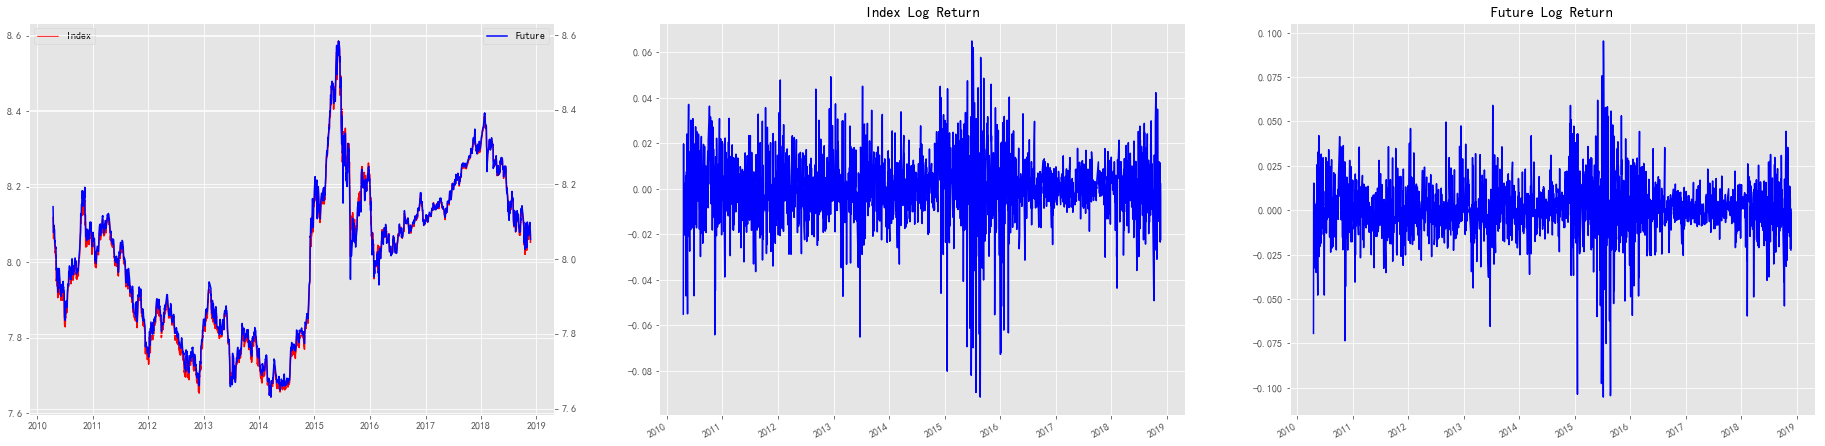

In [15]:
WDB = QS.FactorDB.WindDB2()
WDB.connect()
FT = WDB.getTable("中国A股指数日行情")
DTs = FT.getDateTime(iid="000300.SH", start_dt=StartDT, end_dt=EndDT)
IndexPrice = FT.readData(factor_names=["收盘价(点)"], ids=["000300.SH"], dts=DTs).iloc[0,:,0]
FuturePrice = WDB.getTable("中国股指期货日行情").readData(factor_names=["结算价(元)"], ids=["IF.CFE"], dts=DTs).iloc[0,:,0]
WDB.disconnect()

# 取对数价格和对数收益率
IndexLogPrice, FutureLogPrice = np.log(IndexPrice), np.log(FuturePrice)
IndexLogReturn, FutureLogReturn = IndexLogPrice.diff(), FutureLogPrice.diff()

# 绘制对数价格和对数收益率图像
Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].xaxis_date()
Axes[0].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[0].plot(IndexLogPrice.index, IndexLogPrice.values, color='r', label="Index")
RAxis = Axes[0].twinx()
RAxis.plot(FutureLogPrice.index, FutureLogPrice.values, color='b', label="Future")
Axes[0].legend(loc='upper left')
RAxis.legend(loc='upper right')
IndexLogReturn.plot(ax=Axes[1], color='b', title="Index Log Return")
FutureLogReturn.plot(ax=Axes[2], color='b', title="Future Log Return");

下面对对数价格序列和对数收益率序列进行平稳性检验.

In [16]:
# --------平稳性检验--------
# 对数价格的 ADF 检验
IndexLogPriceADFTest = sm.tsa.stattools.adfuller(IndexLogPrice.values, regression='c', autolag="BIC")
print(("Index Log Price ADF Test Statistic : %f" % IndexLogPriceADFTest[0]), 
      ("pvalue : %f" % IndexLogPriceADFTest[1]), 
      ("usedlag : %d" % IndexLogPriceADFTest[2]), sep="\n")
FutureLogPriceADFTest = sm.tsa.stattools.adfuller(FutureLogPrice.values, regression='c', autolag="BIC")
print(("Future Log Price ADF Test Statistic : %f" % FutureLogPriceADFTest[0]), 
      ("pvalue : %f" % FutureLogPriceADFTest[1]), 
      ("usedlag : %d" % FutureLogPriceADFTest[2]), sep="\n")

Index Log Price ADF Test Statistic : -1.697507
pvalue : 0.432397
usedlag : 0
Future Log Price ADF Test Statistic : -1.720246
pvalue : 0.420713
usedlag : 2


In [17]:
# 对数收益率的 ADF 检验
IndexLogReturnADFTest = sm.tsa.stattools.adfuller(IndexLogReturn.values[1:], regression='c', autolag="BIC")
print(("Index Log Return ADF Test Statistic : %f" % IndexLogReturnADFTest[0]), 
      ("pvalue : %f" % IndexLogReturnADFTest[1]), 
      ("usedlag : %d" % IndexLogReturnADFTest[2]), sep="\n")
FutureLogReturnADFTest = sm.tsa.stattools.adfuller(FutureLogReturn.values[1:], regression='c', autolag="BIC")
print(("Future Log Return ADF Test Statistic : %f" % FutureLogReturnADFTest[0]), 
      ("pvalue : %f" % FutureLogReturnADFTest[1]), 
      ("usedlag : %d" % FutureLogReturnADFTest[2]), sep="\n")

Index Log Return ADF Test Statistic : -44.613224
pvalue : 0.000000
usedlag : 0
Future Log Return ADF Test Statistic : -34.091220
pvalue : 0.000000
usedlag : 1


从平稳性检验的结果来看, 现货和期货的对数价格都不平稳, 而对数收益率是平稳过程, 从而对数价格是 I(1) 过程.

下面对对数价格进行协整检验.

In [18]:
# --------协整检验--------
# 对数价格的 Johansen 协整检验
JohansenTest = sm.tsa.var.vecm.coint_johansen(np.c_[IndexLogPrice.values, FutureLogPrice.values], det_order=0, k_ar_diff=1)
for i in range(JohansenTest.lr1.shape[0]):
    print(("Index - Future Log Price Cointegration Johansen Test Trace Statistic(r<=%d): %f" % (i, JohansenTest.lr1[i])), 
          ("Critical Values (90%%, 95%%, 99%%) for Trace Statistic(r<=%d): %s" % (i, str(JohansenTest.cvt[i]))), 
          ("Maximum Eigenvalue Statistic Statistic(r<=%d): %f" % (i, JohansenTest.lr2[i])), 
          ("Critical Values (90%%, 95%%, 99%%) for Maximum Eigenvalue Statistic(r<=%d): %s" % (i, str(JohansenTest.cvm[i]))), sep="\n")

Index - Future Log Price Cointegration Johansen Test Trace Statistic(r<=0): 121.728347
Critical Values (90%, 95%, 99%) for Trace Statistic(r<=0): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic(r<=0): 118.805630
Critical Values (90%, 95%, 99%) for Maximum Eigenvalue Statistic(r<=0): [12.2971 14.2639 18.52  ]
Index - Future Log Price Cointegration Johansen Test Trace Statistic(r<=1): 2.922718
Critical Values (90%, 95%, 99%) for Trace Statistic(r<=1): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic(r<=1): 2.922718
Critical Values (90%, 95%, 99%) for Maximum Eigenvalue Statistic(r<=1): [2.7055 3.8415 6.6349]


从协整检验的结果来看, 现货和期货的对数价格之间存在协整关系.

下面对对数价格进行 Granger 因果检验.

In [19]:
# --------Granger 因果检验--------
# 现货是否为期货的 Granger 成因
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.c_[FutureLogPrice.values, IndexLogPrice.values], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.7678 , p=0.0002  , df_denom=2090, df_num=1
ssr based chi2 test:   chi2=13.7875 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7423 , p=0.0002  , df=1
parameter F test:         F=13.7678 , p=0.0002  , df_denom=2090, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5720  , p=0.0005  , df_denom=2087, df_num=2
ssr based chi2 test:   chi2=15.1803 , p=0.0005  , df=2
likelihood ratio test: chi2=15.1255 , p=0.0005  , df=2
parameter F test:         F=7.5720  , p=0.0005  , df_denom=2087, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.6861  , p=0.0000  , df_denom=2084, df_num=3
ssr based chi2 test:   chi2=23.1357 , p=0.0000  , df=3
likelihood ratio test: chi2=23.0087 , p=0.0000  , df=3
parameter F test:         F=7.6861  , p=0.0000  , df_denom=2084, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.8165  , p=0.

In [20]:
# 期货是否为现货的 Granger 成因
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.c_[IndexLogPrice.values, FutureLogPrice.values], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0227  , p=0.3120  , df_denom=2090, df_num=1
ssr based chi2 test:   chi2=1.0242  , p=0.3115  , df=1
likelihood ratio test: chi2=1.0239  , p=0.3116  , df=1
parameter F test:         F=1.0227  , p=0.3120  , df_denom=2090, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0917  , p=0.0062  , df_denom=2087, df_num=2
ssr based chi2 test:   chi2=10.2078 , p=0.0061  , df=2
likelihood ratio test: chi2=10.1829 , p=0.0061  , df=2
parameter F test:         F=5.0917  , p=0.0062  , df_denom=2087, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6935  , p=0.0007  , df_denom=2084, df_num=3
ssr based chi2 test:   chi2=17.1379 , p=0.0007  , df=3
likelihood ratio test: chi2=17.0680 , p=0.0007  , df=3
parameter F test:         F=5.6935  , p=0.0007  , df_denom=2084, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4644  , p=0.

从 Granger 因果检验的结果来看:
* 现货是期货的 Granger 成因检验的 p 值在各个滞后阶数下的最大值为滞后阶数取 2 时的 0.0005, 表明在 99.9% 的置信水平下, 可以认为现货价格是期货价格的 Granger 成因
* 期货是现货的 Granger 成因检验的 p 值在各个滞后阶数下的最大值为滞后阶数取 1 时的 0.3120, 无法拒绝原假设, 其他滞后阶数的 p 值也有较大的情况出现, 因此期货价格对现货价格的引导性相对较弱.

从整个样本来看, 现货对期货的引导关系较强.

下面对期货和现货对数价格进行脉冲响应分析.

In [21]:
# --------脉冲响应分析--------
# 建立 VAR 模型
Data = pd.DataFrame(np.c_[FutureLogReturn.values, IndexLogReturn.values][1:,:], index=IndexLogReturn.index[1:], columns=["Future Log Return", "Index Log Return"])
VARModel = sm.tsa.VAR(Data)
# 选择模型的阶数
LagOrderResult = VARModel.select_order(maxlags=10)
LagOrderResult.summary()

,AIC,BIC,FPE,HQIC
0,-18.73,-18.72,7.343e-09,-18.73
1,-18.79,-18.78,6.884e-09,-18.79
2,-18.82,-18.80,6.680e-09,-18.81
3,-18.85,-18.81*,6.492e-09,-18.84
4,-18.86,-18.81,6.450e-09,-18.84
5,-18.87,-18.81,6.403e-09,-18.84
6,-18.87,-18.80,6.350e-09,-18.85
7,-18.88,-18.80,6.318e-09,-18.85
8,-18.88,-18.79,6.304e-09,-18.85
9,-18.89,-18.79,6.256e-09,-18.85*


In [22]:
# 估计模型参数
Result = VARModel.fit(3, trend="nc")
Result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Nov, 2018
Time:                     14:58:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.8230
Nobs:                     2090.00    HQIC:                  -18.8435
Log likelihood:           13784.7    FPE:                6.47446e-09
AIC:                     -18.8554    Det(Omega_mle):     6.43744e-09
--------------------------------------------------------------------
Results for equation Future Log Return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
L1.Future Log Return        -0.130403         0.061722           -2.113           0.035
L1.Index Log Return          0.205089         0.064447            3.182           0.001
L2.Future Log Return

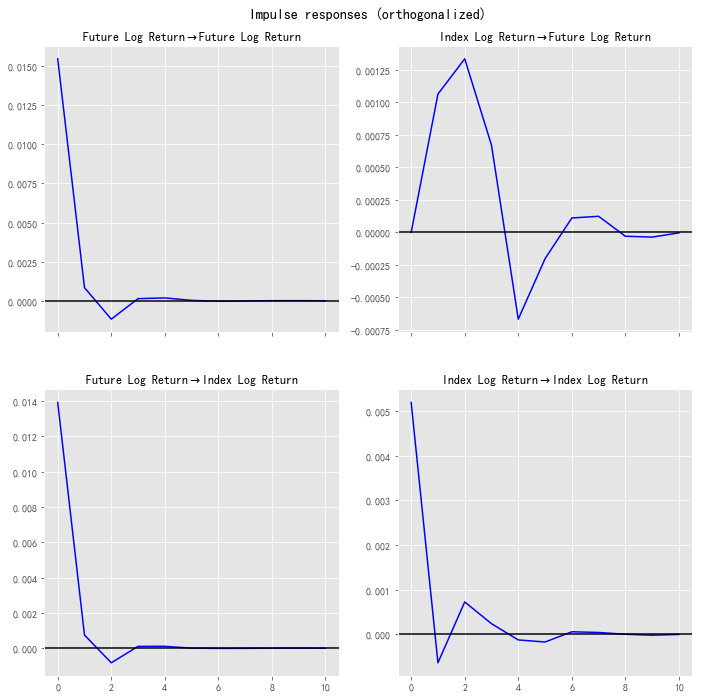

In [23]:
# 脉冲响应分析
IRFResult = Result.irf(periods=10)
IRFResult.plot(orth=True, plot_stderr=False);

### 日内数据

In [24]:
IntradayStartDT, IntradayEndDT = dt.datetime(2018,11,1), dt.datetime(2018,11,23)

以下以沪深 300 指数和股指期货(主力合约)的对数收益率作为样本进行引导关系的检验. 样本选取 {{IntradayStartDT.strftime("%Y-%m-%d")}} 至 {{IntradayEndDT.strftime("%Y-%m-%d")}} 的 1 分钟数据.

首先获取分钟数据.

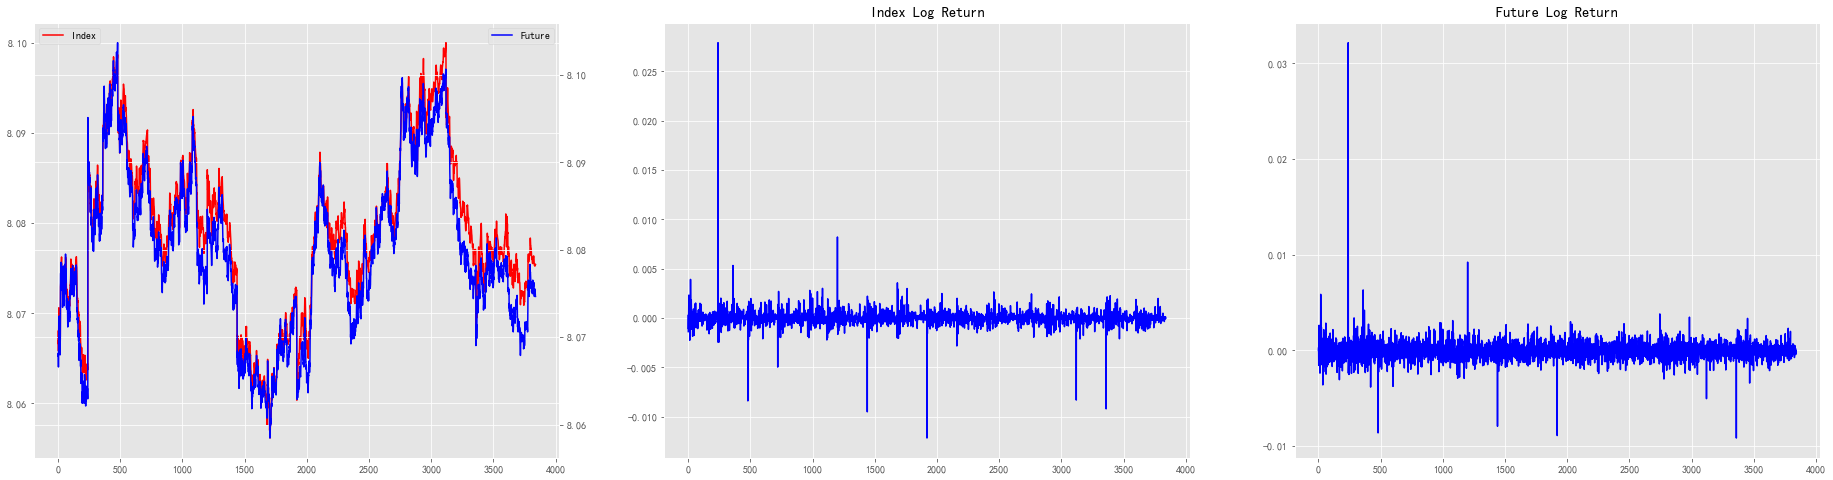

In [28]:
ADB = QS.FactorDB.ArcticDB()
ADB.connect()
FT = ADB.getTable("MinuteBar")
DTs = FT.getDateTime(iid="000300.SH", start_dt=IntradayStartDT, end_dt=IntradayEndDT)
FuturePrice = FT.readData(factor_names=["最新价"], ids=["000300.SH", "IF00"], dts=DTs).iloc[0,:,:]
IndexPrice, FuturePrice = FuturePrice.iloc[:, 0], FuturePrice.iloc[:, 1]
ADB.disconnect()

# 取对数价格和对数收益率
IndexLogPrice, FutureLogPrice = np.log(IndexPrice), np.log(FuturePrice)
IndexLogReturn, FutureLogReturn = IndexLogPrice.diff(), FutureLogPrice.diff()

# 绘制对数价格和对数收益率图像
Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(IndexLogPrice.values, color='r', label="Index")
RAxis = Axes[0].twinx()
RAxis.plot(FutureLogPrice.values, color='b', label="Future")
Axes[0].legend(loc='upper left')
RAxis.legend(loc='upper right')
Axes[1].plot(IndexLogReturn.values, color='b')
Axes[1].set_title("Index Log Return")
Axes[2].plot(FutureLogReturn.values, color='b')
Axes[2].set_title("Future Log Return");

In [29]:
# --------平稳性检验--------
# 对数价格的 ADF 检验
IndexLogPriceADFTest = sm.tsa.stattools.adfuller(IndexLogPrice.values, regression='c', autolag="BIC")
print(("Index Log Price ADF Test Statistic : %f" % IndexLogPriceADFTest[0]), 
      ("pvalue : %f" % IndexLogPriceADFTest[1]), 
      ("usedlag : %d" % IndexLogPriceADFTest[2]), sep="\n")
FutureLogPriceADFTest = sm.tsa.stattools.adfuller(FutureLogPrice.values, regression='c', autolag="BIC")
print(("Future Log Price ADF Test Statistic : %f" % FutureLogPriceADFTest[0]), 
      ("pvalue : %f" % FutureLogPriceADFTest[1]), 
      ("usedlag : %d" % FutureLogPriceADFTest[2]), sep="\n")

Index Log Price ADF Test Statistic : -3.144452
pvalue : 0.023434
usedlag : 1
Future Log Price ADF Test Statistic : -3.285867
pvalue : 0.015522
usedlag : 1


In [30]:
# 对数收益率的 ADF 检验
IndexLogReturnADFTest = sm.tsa.stattools.adfuller(IndexLogReturn.values[1:], regression='c', autolag="BIC")
print(("Index Log Return ADF Test Statistic : %f" % IndexLogReturnADFTest[0]), 
      ("pvalue : %f" % IndexLogReturnADFTest[1]), 
      ("usedlag : %d" % IndexLogReturnADFTest[2]), sep="\n")
FutureLogReturnADFTest = sm.tsa.stattools.adfuller(FutureLogReturn.values[1:], regression='c', autolag="BIC")
print(("Future Log Return ADF Test Statistic : %f" % FutureLogReturnADFTest[0]), 
      ("pvalue : %f" % FutureLogReturnADFTest[1]), 
      ("usedlag : %d" % FutureLogReturnADFTest[2]), sep="\n")

Index Log Return ADF Test Statistic : -57.809261
pvalue : 0.000000
usedlag : 0
Future Log Return ADF Test Statistic : -65.696682
pvalue : 0.000000
usedlag : 0


In [31]:
# --------协整检验--------
# 对数价格的 Johansen 协整检验
JohansenTest = sm.tsa.var.vecm.coint_johansen(np.c_[IndexLogPrice.values, FutureLogPrice.values], det_order=0, k_ar_diff=1)
for i in range(JohansenTest.lr1.shape[0]):
    print(("Index - Future Log Price Cointegration Johansen Test Trace Statistic(r<=%d): %f" % (i, JohansenTest.lr1[i])), 
          ("Critical Values (90%%, 95%%, 99%%) for Trace Statistic(r<=%d): %s" % (i, str(JohansenTest.cvt[i]))), 
          ("Maximum Eigenvalue Statistic Statistic(r<=%d): %f" % (i, JohansenTest.lr2[i])), 
          ("Critical Values (90%%, 95%%, 99%%) for Maximum Eigenvalue Statistic(r<=%d): %s" % (i, str(JohansenTest.cvm[i]))), sep="\n")

Index - Future Log Price Cointegration Johansen Test Trace Statistic(r<=0): 114.863031
Critical Values (90%, 95%, 99%) for Trace Statistic(r<=0): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic(r<=0): 104.361951
Critical Values (90%, 95%, 99%) for Maximum Eigenvalue Statistic(r<=0): [12.2971 14.2639 18.52  ]
Index - Future Log Price Cointegration Johansen Test Trace Statistic(r<=1): 10.501080
Critical Values (90%, 95%, 99%) for Trace Statistic(r<=1): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic(r<=1): 10.501080
Critical Values (90%, 95%, 99%) for Maximum Eigenvalue Statistic(r<=1): [2.7055 3.8415 6.6349]


In [32]:
# --------Granger 因果检验--------
# 现货是否为期货的 Granger 成因
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.c_[FutureLogPrice.values, IndexLogPrice.values], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6517  , p=0.4195  , df_denom=3836, df_num=1
ssr based chi2 test:   chi2=0.6522  , p=0.4193  , df=1
likelihood ratio test: chi2=0.6522  , p=0.4193  , df=1
parameter F test:         F=0.6517  , p=0.4195  , df_denom=3836, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0386  , p=0.9622  , df_denom=3833, df_num=2
ssr based chi2 test:   chi2=0.0772  , p=0.9621  , df=2
likelihood ratio test: chi2=0.0772  , p=0.9621  , df=2
parameter F test:         F=0.0386  , p=0.9622  , df_denom=3833, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1895  , p=0.9036  , df_denom=3830, df_num=3
ssr based chi2 test:   chi2=0.5697  , p=0.9033  , df=3
likelihood ratio test: chi2=0.5696  , p=0.9033  , df=3
parameter F test:         F=0.1895  , p=0.9036  , df_denom=3830, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2276  , p=0.

In [33]:
# 期货是否为现货的 Granger 成因
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.c_[IndexLogPrice.values, FutureLogPrice.values], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=55.4840 , p=0.0000  , df_denom=3836, df_num=1
ssr based chi2 test:   chi2=55.5274 , p=0.0000  , df=1
likelihood ratio test: chi2=55.1297 , p=0.0000  , df=1
parameter F test:         F=55.4840 , p=0.0000  , df_denom=3836, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=65.4220 , p=0.0000  , df_denom=3833, df_num=2
ssr based chi2 test:   chi2=131.0146, p=0.0000  , df=2
likelihood ratio test: chi2=128.8281, p=0.0000  , df=2
parameter F test:         F=65.4220 , p=0.0000  , df_denom=3833, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=52.7279 , p=0.0000  , df_denom=3830, df_num=3
ssr based chi2 test:   chi2=158.4729, p=0.0000  , df=3
likelihood ratio test: chi2=155.2877, p=0.0000  , df=3
parameter F test:         F=52.7279 , p=0.0000  , df_denom=3830, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=44.4943 , p=0.

In [34]:
# --------脉冲响应分析--------
# 建立 VAR 模型
Data = pd.DataFrame(np.c_[FutureLogReturn.values, IndexLogReturn.values][1:,:], index=IndexLogReturn.index[1:], columns=["Future Log Return", "Index Log Return"])
VARModel = sm.tsa.VAR(Data)
# 选择模型的阶数
LagOrderResult = VARModel.select_order(maxlags=10)
LagOrderResult.summary()

,AIC,BIC,FPE,HQIC
0,-29.13,-29.13,2.229e-13,-29.13
1,-29.29,-29.28,1.906e-13,-29.29
2,-29.34,-29.33,1.807e-13,-29.34
3,-29.36,-29.34,1.774e-13,-29.35
4,-29.37,-29.34*,1.754e-13,-29.36
5,-29.38,-29.34,1.748e-13,-29.36
6,-29.38,-29.34,1.739e-13,-29.37*
7,-29.38,-29.33,1.741e-13,-29.36
8,-29.38,-29.33,1.736e-13,-29.36
9,-29.38,-29.32,1.735e-13,-29.36


In [35]:
# 估计模型参数
Result = VARModel.fit(4, trend="nc")
Result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Nov, 2018
Time:                     15:31:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.3421
Nobs:                     3835.00    HQIC:                  -29.3589
Log likelihood:           45446.2    FPE:                1.76020e-13
AIC:                     -29.3682    Det(Omega_mle):     1.75288e-13
--------------------------------------------------------------------
Results for equation Future Log Return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
L1.Future Log Return        -0.071475         0.030669           -2.331           0.020
L1.Index Log Return          0.014870         0.039290            0.378           0.705
L2.Future Log Return

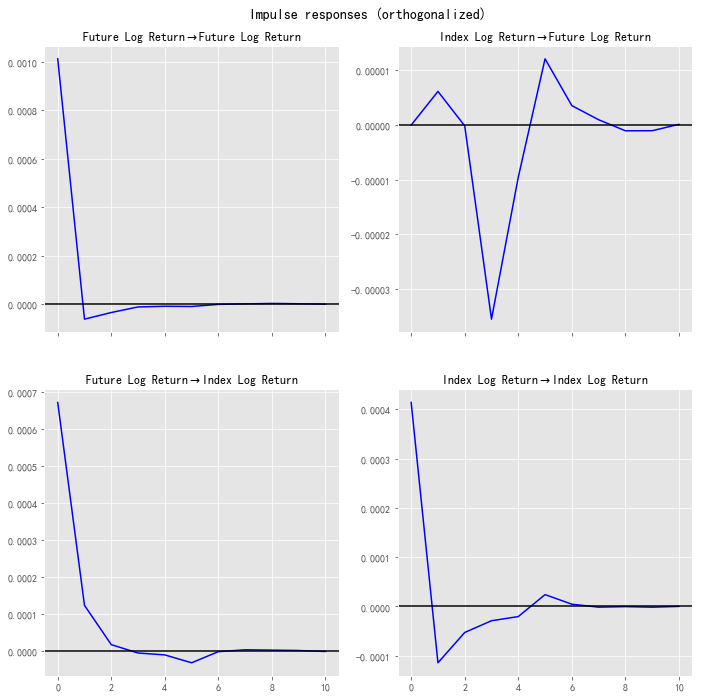

In [36]:
# 脉冲响应分析
IRFResult = Result.irf(periods=10)
IRFResult.plot(orth=True, plot_stderr=False);